In [27]:
run "robotworld.py"

ITERATION 0
(19.0, 19.0)
0.0 (7.087626433942257e-13, 0.047619047619047616)
0.06346651825433926 (9.674722802463088e-13, 0.047619047619047616)
0.12693303650867852 (8.631832963919123e-13, 0.047619047619047616)
0.1903995547630178 (7.316214404786318e-13, 0.047619047619047616)
0.25386607301735703 (7.453552923414591e-13, 0.047619047619047616)
0.3173325912716963 (6.525721299627508e-13, 0.047619047619047616)
0.3807991095260356 (5.234258549080894e-13, 0.047619047619047616)
0.4442656277803748 (4.125136955579189e-13, 0.047619047619047616)
0.5077321460347141 (5.861914304985756e-13, 0.047619047619047616)
0.5711986642890533 (4.955552009864529e-13, 0.047619047619047616)
0.6346651825433925 (5.35899274755624e-13, 0.047619047619047616)
0.6981317007977318 (8.870436550047859e-13, 0.047619047619047616)
0.7615982190520711 (6.939186195259149e-13, 0.047619047619047616)
0.8250647373064104 (6.194054672410009e-13, 0.047619047619047616)
0.8885312555607496 (2.934648518126579e-13, 0.047619047619047616)
0.95199777381

1.6501294746128208 (4.1143969959274516e-13, 0.047619047619047616)
1.71359599286716 (6.131863077579388e-13, 0.047619047619047616)
1.7770625111214993 (6.569928731021739e-13, 0.047619047619047616)
1.8405290293758385 (4.782366034250054e-13, 0.047619047619047616)
1.9039955476301778 (6.874986166023389e-13, 0.047619047619047616)
1.967462065884517 (9.837865387251108e-13, 0.047619047619047616)
2.0309285841388562 (9.459167305836773e-13, 0.047619047619047616)
2.0943951023931957 (1.991596462914493e-12, 0.047619047619047616)
2.1578616206475347 (1.5424437906257921e-12, 0.047619047619047616)
2.221328138901874 (1.5061143616850611e-12, 0.047619047619047616)
2.284794657156213 (2.297657215052709e-12, 0.047619047619047616)
2.3482611754105527 (3.5159246293573872e-12, 0.047619047619047616)
2.4117276936648917 (1.7530012431678494e-12, 0.047619047619047616)
2.475194211919231 (2.9701350909768628e-12, 0.047619047619047616)
2.53866073017357 (8.326357074656355e-12, 0.047619047619047616)
2.6021272484279097 (5.05575

3.3637254674799806 (1.344268310457738e-12, 0.047619047619047616)
3.42719198573432 (1.858636008134877e-12, 0.047619047619047616)
3.490658503988659 (3.5059267175020564e-12, 0.047619047619047616)
3.5541250222429985 (1.8109086904136109e-12, 0.047619047619047616)
3.6175915404973376 (3.568723864398974e-12, 0.047619047619047616)
3.681058058751677 (2.1106585995191676e-12, 0.047619047619047616)
3.744524577006016 (3.2220411796241813e-12, 0.047619047619047616)
3.8079910952603555 (1.751027542698025e-12, 0.047619047619047616)
3.8714576135146945 (3.5898207802705636e-12, 0.047619047619047616)
3.934924131769034 (3.1274746691105807e-12, 0.047619047619047616)
3.998390650023373 (6.346706357379178e-12, 0.047619047619047616)
4.0618571682777125 (1.9189453788390238e-12, 0.047619047619047616)
4.1253236865320515 (3.757956578358097e-12, 0.047619047619047616)
4.188790204786391 (3.3276545809420556e-12, 0.047619047619047616)
4.25225672304073 (2.0121798923877633e-12, 0.047619047619047616)
4.3157232412950695 (1.6448

KeyboardInterrupt: 

In [7]:
path = p.testValueFunction(p.VPGS[-1],19.0,19.0,40)

19.0 19.0
18.230316310009886 18.09076551345094
17.884256550643233 17.507314056593515
17.48253531064651 16.655078334033682
17.759043305697396 15.593540969403199
17.282969160364402 15.04899430070519
17.810525558291594 14.069511896414246
17.03788173133843 13.28591497591554
17.496942904338706 12.225194049654332
17.609120532472563 11.480220837348023
17.687190989714235 10.564865129056688
17.793768651708785 9.450641193994961
17.157780751826568 8.69172291330687
17.379102320690617 7.938387349622662
17.280059767426437 7.1065853175357026
17.505486496186787 6.02115320714059
17.29327561477133 4.711380176084076
16.87061193187827 3.365138894322765
16.169049222841817 2.8236384213368386
14.75072502963841 2.8585161387395974
14.143636002670306 3.0178693605878832
13.197816169026057 2.527590803602728
12.285254460138392 2.6858679476594203
11.34740383659022 2.205305520047234
10.152289924989946 2.3260773912954957
9.19386326009179 2.3980091421117327
8.476380589116264 2.416359272192197
7.412243421457892 2.14889

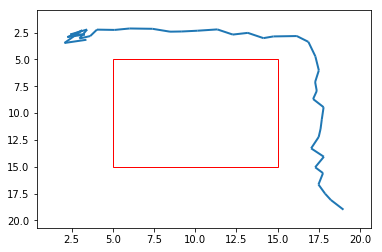

In [8]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc
import matplotlib.patches as patches
lines = []
for i in xrange(len(path)-1):
    lines.append([path[i],path[i+1]])

obstacles = []
for obs in p.obstacles:
    rec = patches.Rectangle((obs.bounds[0],obs.bounds[1]),obs.bounds[2]-obs.bounds[0],obs.bounds[3]-obs.bounds[1],linewidth=1,edgecolor='r',facecolor='none')
    obstacles.append(rec)


lc = mc.LineCollection(lines,linewidths=2)
fig, ax = pl.subplots()
# pl.plot([i[0] for i in path], [i[1] for i in path], 'ro')
for rec in obstacles:
    ax.add_patch(rec)

ax.add_collection(lc)
ax.autoscale()
ax.invert_yaxis()
ax.margins(0.1)